## Predictions

### Prep 

In [1]:
sample_path = 'TestImages'
random_sample = True
encoding_path = 'one_hot_encoding.csv'
model_path = 'Results/r50v2_3'

In [2]:
import numpy as np
import os
from PIL import Image
import tensorflow as tf

IMAGE_SHAPE = (224,224)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
from tensorflow.keras.applications import resnet_v2
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

INPUT_DIM = IMAGE_SHAPE + (3,)
DROPOUT_PROP = 0.5
LEARNING_RATE = 0.001

preprocess_input = resnet_v2.preprocess_input
base_model = resnet_v2.ResNet50V2(input_shape=INPUT_DIM,include_top=False,weights='imagenet')
base_model.trainable = False
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
output_layer = layers.Dense(149,activation='softmax',kernel_regularizer=tf.keras.regularizers.l2(0.001))

inputs = tf.keras.Input(shape=(224, 224, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(DROPOUT_PROP)(x)
outputs = output_layer(x)
model = tf.keras.Model(inputs, outputs)

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.load_weights(model_path)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                             

### Load model and image pool

In [4]:
from tensorflow.keras.utils import image_dataset_from_directory
import pandas as pd

data = pd.read_csv('pokemon.csv')
data = data[data['generation'] == 1]
lookup = pd.Index(data['name'])
encoding = pd.read_csv(encoding_path, index_col=0)

sample_dataset = image_dataset_from_directory(sample_path, shuffle=random_sample, image_size=IMAGE_SHAPE, batch_size=1)

def get_stats(names):
    indexes = [lookup.get_loc(n) for n in names]

    print(('HP:{}\t\t\t\t\tHP:{}\t\t\t\t\tHP:{}'.format(data['hp'][indexes[0]],data['hp'][indexes[1]],data['hp'][indexes[2]])))
    print(('Capture Rate:{}\t\t\tCapture Rate:{}\t\t\t\tCapture Rate:{}'.format(data['capture_rate'][indexes[0]],data['capture_rate'][indexes[1]],data['capture_rate'][indexes[2]])))
    print(('Weight(kg):{}\t\t\t\tWeight(kg):{}\t\t\t\tWeight(kg):{}'.format(data['weight_kg'][indexes[0]],data['weight_kg'][indexes[1]],data['weight_kg'][indexes[2]])))
    print(('Speed:{}\t\t\t\tSpeed:{}\t\t\t\tSpeed:{}'.format(data['speed'][indexes[0]],data['speed'][indexes[1]],data['speed'][indexes[2]])))

Found 949 files belonging to 149 classes.


In [5]:
import matplotlib.pyplot as plt

def run_on_image(sample, imagepath='TrainImages'):
    # Show input
    plt.figure(figsize=(10, 8))
    ax = plt.subplot(2, 3, 2)
    for image, label in sample:
        # Get top 3 predictions with confidence
        output = model.predict(image).flatten()
        top = np.argsort(-output)[:3]
        pred = [(encoding.name.iloc[t], output[t] * 100) for t in top]

        plt.imshow(image[0].numpy().astype('uint8'))
        plt.title('Input Image: {}'.format(sample_dataset.class_names[label[0]]))
        plt.axis("off")

    # Show results
    for i in range(3):
        ax = plt.subplot(2, 3, i + 4)
        imagesource = imagepath + '/' + pred[i][0]
        images = os.listdir(imagesource)
        r = int(np.random.rand() * len(images))
        img = Image.open(imagesource + '/' + images[r])
        plt.imshow(img)
        plt.title("{} - {:.2f}%".format(pred[i][0], pred[i][1]))
        plt.axis("off")
        
    plt.show()
    return pred
    

### Run on random image

1/1 [==============================] - 0s 71ms/step


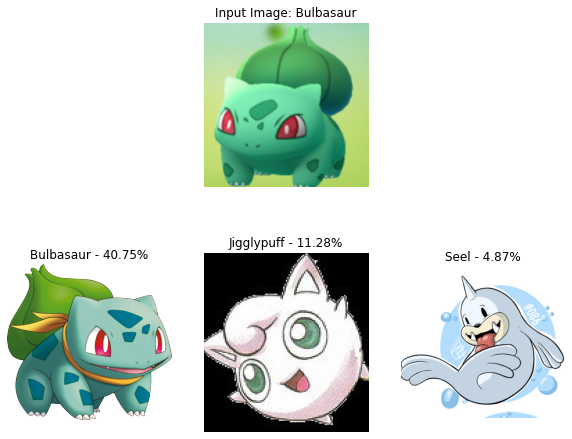

HP:45					HP:115					HP:65
Capture Rate:45			Capture Rate:170				Capture Rate:190
Weight(kg):6.9				Weight(kg):5.5				Weight(kg):90.0
Speed:45				Speed:20				Speed:45


In [19]:
pred = run_on_image(sample_dataset.take(1))

names = []
for i in range(0,3):
    names.append(pred[i][0])

get_stats(names)